# Quick Draw Dataset

In this notebook, a model trained on subset of Quick Draw dataset is ananlysed. I use only 340,000 images in total, i.e., 1000 images per category. Also, I convert samples from strokes into images on the fly during training process. Probably it makes more sense to save everything onto disk at first. However, for a basic analysis and overview it should be fine to go with this approach.

## Imports

In [20]:
%reload_ext autoreload
%autoreload 2

In [21]:
import sys
from pathlib import Path
from dataclasses import dataclass
from operator import itemgetter
from itertools import chain, cycle
from multiprocessing import Pool, cpu_count

In [22]:
parent_dir = Path.cwd().parent.as_posix()
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from PIL import ImageDraw as PILDraw

import torch
from torchvision import models
from torchvision.transforms.functional import to_tensor
from fastai import *
from fastai.vision import *
from fastai.basic_data import DatasetType

In [24]:
from doodles_dataset import QuickDraw, TRAIN_DATA, PREPARED, to_string, to_pil_image

In [ ]:
defaults.device = torch.device('cuda:1')

In [ ]:
IMG_SZ = 256, 256
RANDOM_STATE = 1

In [ ]:
np.random.seed(RANDOM_STATE)

## Dataset Review

In [ ]:
!ls $TRAIN_DATA

In [ ]:
dogs = pd.read_csv(TRAIN_DATA/'dog.csv')
dogs = dogs[dogs.recognized]

In [ ]:
dogs.sample(5)

In [ ]:
def to_flat_list(segments):
    return list(chain(*chain(*[zip(*segment) for segment in eval(segments)])))

In [ ]:
flat_coords = dogs.drawing.sample(1000).map(to_flat_list)
min_val = flat_coords.map(min).min()
max_val = flat_coords.map(max).max()
print(f'Doodle coordinates are in range from {min_val} to {max_val}')

In [ ]:
COLORS = cycle(['#0095EF', '#3C50B1', '#6A38B3', '#A224AD', '#F31D64', '#FE433C'])

In [ ]:
def to_pil_image(strokes, size=max_val+1, color='white', lw=3, colors=COLORS):
    canvas = PILImage.new('RGB', (size, size), color='white')
    draw = PILDraw.Draw(canvas)
    for segment, color in zip(strokes, colors):
        xs, ys = segment
        prev_pts = zip(xs[:-1], ys[:-1])
        next_pts = zip(xs[1:], ys[1:])
        for (x1, y1), (x2, y2) in zip(prev_pts, next_pts):
            draw.line((x1, y1, x2, y2), fill=color, width=lw)
    return canvas

In [ ]:
def draw_sample(df, title=None, n=16, n_cols=4, figsize=(10, 10), dpi=70):
    n_rows = n//n_cols
    f, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=dpi)
    examples = df.sample(n).drawing.map(eval)
    for strokes, ax in zip(examples, axes.flat):
        img = to_pil_image(strokes)
        ax.imshow(img)
        ax.set_axis_off()
    if title is not None:
        f.suptitle(title, fontsize=20)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
draw_sample(dogs, 'Dogs')

## Custom Dataset

The custom dataset definition is provided in [doodles_dataset.py](./doodles_dataset.py) file. The main idea here is to load CSV file only, and then generate strokes into PIL images on demand. The logic here is that reading small b/w image from I/O device probably comparable with generating it from scratch. 

Here is a part of PyTorch Dataset API which takes sequence of (x, y) coordinates concatenated into single comma-separated string and converts it into image:

```python
def __getitem__(self, item):
    points, target = self.data[item], self.labels[item]
    image = self.to_pil_image(points)
    return image, target

def to_pil_image(self, points):
    canvas = PILImage.new('RGB', self.img_size, color=self.bg_color)
    draw = PILDraw.Draw(canvas)
    chunks = [int(x) for x in points.split(',')]
    while len(chunks) >= 4:
        line, chunks = chunks[:4], chunks[2:]
        draw.line(tuple(line), fill=self.stroke_color, width=self.lw)
    image = Image(to_tensor(canvas))
    return image
```

Also, I am using a custom decorator to make the dataset compatible with `fastai` classes. The decorator attaches two properties, namely, `c` and `loss_func` to the dataset class.

```python
def fastai_dataset(loss_func):

    def class_wrapper(dataset_cls):

        def get_n_classes(self):
            return len(self.classes)

        def get_loss_func(self):
            return loss_func

        dataset_cls.c = property(get_n_classes)
        dataset_cls.loss_func = property(get_loss_func)
        return dataset_cls

    return class_wrapper
```

## Loading Trained Model

The model training process is implemented in the file referenced above and was performed using CLI. Here we're going to load previously trained model. For this purpose, we need to re-build data loading pipeline, instantiate learner object, and load previously saved weights.

In [ ]:
train_ds = QuickDraw(PREPARED, train=True, take_subset=True, use_cache=True)
valid_ds = QuickDraw(PREPARED, train=False, take_subset=True, use_cache=True)

In [ ]:
test_ds = ImageClassificationDataset.from_single_folder(PREPARED.parent/'test'/'images', classes=train_ds.classes)

In [ ]:
batch_size = 300
image_size = 256

In [ ]:
bunch = ImageDataBunch.create(
    train_ds, valid_ds, test_ds,
    bs=batch_size, size=image_size, ds_tfms=get_transforms())

bunch.normalize(imagenet_stats)

In [ ]:
bunch.show_batch(4, figsize=(10, 10))

In [ ]:
learn = create_cnn(bunch, models.resnet50, path='..')

In [ ]:
# learn.fit_one_cycle(args['n_epochs'], callbacks=[SaveModelCallback(learn)])

In [ ]:
# learn.save('sz_224')

In [ ]:
learn.load('resnet50_final_224')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

## Model Interpretation

In [ ]:
acc = (interp.pred_class == interp.y_true).float().mean().numpy().item()
print(f'Validation accuracy: {acc:2.2%}')

In [ ]:
interp.plot_top_losses(k=16, figsize=(14, 14))

In [ ]:
most_confused = interp.most_confused(slice_size=1000)

In [ ]:
most_confused[:10]

In [ ]:
test_data = pd.read_csv(PREPARED.parent/'test'/'test_simplified.csv')

In [ ]:
test_data.shape

In [ ]:
test_data.head()

Now we can run predictions against test data. For this purpose, let's create a small helper class that generates top-k predictions from PIL image or tensor.

In [ ]:
@dataclass
class Predictor:
    learn: Learner
    mean: FloatTensor
    std: FloatTensor
        
    def __post_init__(self):
        device = self.learn.data.device
        self.learn.model.eval()
        self.mean, self.std = [torch.tensor(x).to(device) for x in (self.mean, self.std)]
    
    def predict(self, x):
        out = self.predict_logits(x)
        best_index = out.argmax()
        return self.learn.data.classes[best_index]
    
    def predict_top(self, x, k=1):
        out = self.predict_logits(x)
        preds = sorted([
            (i, x.item(), self.learn.data.classes[i]) 
            for i, x in enumerate(out.flatten())],
            reverse=True, key=itemgetter(1))[:k]
        return preds
    
    def predict_logits(self, x):
        x = self._to_tensor(x)
        out = self.learn.model(x[None])
        return out
            
    def _to_tensor(self, x):
        if isinstance(x, str):
            data = open_image(x).data
        elif isinstance(x, PILImage.Image):
            data = to_tensor(x)
        else:
            data = torch.tensor(x)
        x = data.to(self.learn.data.device)
        x = normalize(x, self.mean, self.std)
        return x

In [ ]:
predictor = Predictor(learn, *imagenet_stats)

In [ ]:
img = to_pil_image(to_string(test_data.drawing[0]), IMG_SZ)
img

In [ ]:
predictor.predict_top(img, 5)

In [ ]:
images = torch.stack([to_tensor(to_pil_image(to_string(test_data.drawing[i]), IMG_SZ)) for i in range(5)])

In [ ]:
learn.model(images.to('cuda:1'))

In [ ]:
preds = learn.get_preds(is_test=True)

In [ ]:
y_hat, y_true = preds

In [ ]:
y_hat.shape

In [ ]:
y_true.shape

In [ ]:
torch.save({'y_hat': y_hat, 'y_true': y_true}, Path.home()/'data'/'doodle'/'preds.pt')

In [37]:
preds_data = torch.load(Path.home()/'data'/'doodle'/'preds.pt')
y_hat = preds_data['y_hat']
y_true = preds_data['y_true']

In [39]:
def top_k(learn, logits, k=3):
    top_idx = logits.argsort()[:, -k:]
    top_classes = learn.data.classes[top_idx]
    top_logits = logits[np.arange(len(logits)), top_idx.T].T
    return np.fliplr(top_classes), np.fliplr(top_logits)

In [ ]:
classes, losses = top_k(learn, y_hat.numpy())

In [ ]:
r, c = 5, 3

In [ ]:
sample = np.random.permutation(len(learn.data.test_ds))[:r*c]

In [ ]:
sample_img = [learn.data.test_ds[idx][0].data.permute(1, 2, 0) for idx in sample]
sample_cls = classes[sample]
sample_los = losses[sample]

In [ ]:
from plots import plot_predictions

In [ ]:
f, axes = plt.subplots(r, c, figsize=(15, 15), dpi=70)
for i, ax in zip(sample, axes.flat):
    img, _ = learn.data.test_ds[i]
    np_img = img.data.permute(1, 2, 0).numpy()
    cls, los = classes[i], losses[i]
    plot_predictions(np_img, dict(zip(cls, los)), ax=ax, sort_by_probability=True)

In [ ]:
keys = [path.stem for path in learn.data.test_ds.x]

In [ ]:
records = ['key_id,word']

for key, top_classes in zip(keys, classes):
    str_classes = ' '.join(['_'.join(c.split()) for c in top_classes])
    records.append(f'{key},{str_classes}')
    
with open('submit.csv', 'w') as file:
    for record in records:
        file.write(record + '\n')

## Trying to achieve better results

The previous model was trained using 10000 images per category, using ResNet50 model during 3 training epochs. In this section, we're going to try see how different architectures could influence model accuracy. Then when the best model is selected, we can train the model using bigger subset of data.

Training takes a lot of time so using a subset only allows to speed up prototyping and analysis.

In [1]:
from pathlib import Path

import torch
from torchvision import models
from fastai import defaults
from fastai.vision import *
from fastai.metrics import accuracy, error_rate
from fastai.callback import annealing_cos
from fastai.callbacks.general_sched import GeneralScheduler, TrainingPhase

In [2]:
defaults.device = torch.device('cuda:1')

In [3]:
PATH = Path.home()/'data'/'doodle'/'images'

In [4]:
bunch = ImageDataBunch.from_folder(PATH, bs=400, size=224, ds_tfms=get_transforms())

In [5]:
learn = create_cnn(bunch, models.resnet18, metrics=[accuracy, error_rate], path='..')

In [6]:
learn.lr_find(start_lr=1e-07, end_lr=1e-2)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


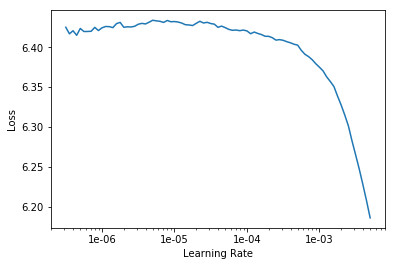

In [7]:
learn.recorder.plot()

In [13]:
def sgd_warm_phases(
    learn, n_cycles, cycle_mult=2, cycle_len=1, mom=0.8, lr=1e-3):

    n_batches = len(learn.data.train_dl)
    
    phases = [
        TrainingPhase(
            n_batches*(cycle_len * cycle_mult**i),
            lrs=lr, moms=mom, lr_anneal=annealing_cos
        ) for i in range(n_cycles)]

    if cycle_mult == 1:
        total_epochs = n_cycles * cycle_len
    else:
        total_epochs = int(
            cycle_len*(1 - cycle_mult**n_cycles)/(1 - cycle_mult))

    return total_epochs, phases

In [8]:
learn.unfreeze()
learn.freeze_to(-1)
learn.fit_one_cycle(1, max_lr=slice(1e-3, 5e-2))

Total time: 07:05
epoch  train_loss  valid_loss  accuracy  error_rate
1      1.737476    1.250048    0.664029  0.335971    (07:05)



In [9]:
learn.unfreeze()
learn.freeze_to(-2)
learn.fit_one_cycle(3, max_lr=slice(5e-4, 5e-3))

Total time: 22:58
epoch  train_loss  valid_loss  accuracy  error_rate
1      1.559047    1.261772    0.657853  0.342147    (07:37)
2      1.201918    0.920711    0.739706  0.260294    (07:40)
3      0.982593    0.803438    0.770529  0.229471    (07:40)



In [10]:
learn.freeze()
learn.lr_find(start_lr=1e-07, end_lr=1e-2)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


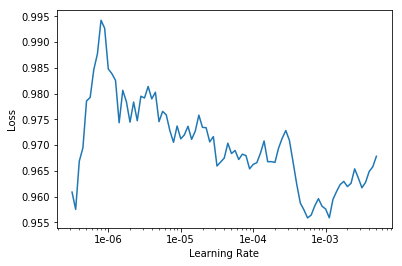

In [11]:
learn.recorder.plot()

In [14]:
n, phases = sgd_warm_phases(learn, 3, lr=5e-4)
sched = GeneralScheduler(learn, phases=phases)
learn.unfreeze()
learn.fit(n, callbacks=[sched])

Total time: 1:04:41
epoch  train_loss  valid_loss  accuracy  error_rate
1      0.944947    0.776181    0.778029  0.221971    (09:14)
2      0.951187    0.772774    0.778853  0.221147    (09:14)
3      0.849018    0.740994    0.786177  0.213824    (09:14)
4      0.922332    0.778744    0.777588  0.222412    (09:12)
5      0.857268    0.745938    0.784882  0.215118    (09:14)
6      0.792569    0.717464    0.794206  0.205794    (09:15)
7      0.748054    0.708906    0.795294  0.204706    (09:15)



In [15]:
learn.freeze()
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


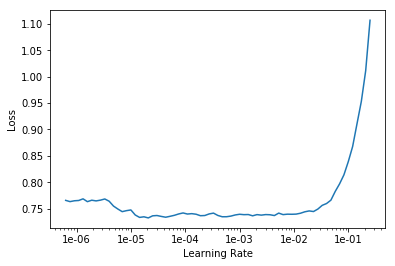

In [16]:
learn.recorder.plot()

In [17]:
learn.save('resnet18_notebook')

In [25]:
train_ds = ImageClassificationDataset.from_folder(PATH/'train')
valid_ds = ImageClassificationDataset.from_folder(PATH/'valid')
test_ds = ImageClassificationDataset.from_single_folder(PREPARED.parent/'test'/'images', classes=train_ds.classes)

In [26]:
bunch = ImageDataBunch.create(train_ds, valid_ds, test_ds, bs=400, size=224, ds_tfms=get_transforms())

In [27]:
learn = create_cnn(bunch, models.resnet18, metrics=[accuracy, error_rate], path='..')

In [28]:
learn.load('resnet18_notebook')

In [31]:
preds, _ = learn.get_preds(DatasetType.Test)

In [45]:
def top_k(learn, logits, k=3):
    top_idx = logits.argsort()[:, -k:]
    top_classes = np.array(learn.data.classes)[top_idx]
    top_logits = logits[np.arange(len(logits)), top_idx.T].T
    return np.fliplr(top_classes), np.fliplr(top_logits)

In [46]:
classes, losses = top_k(learn, preds.numpy())

In [49]:
r, c = 5, 3

In [50]:
sample = np.random.permutation(len(learn.data.test_ds))[:r*c]

In [51]:
sample_img = [learn.data.test_ds[idx][0].data.permute(1, 2, 0) for idx in sample]
sample_cls = classes[sample]
sample_los = losses[sample]

In [52]:
from plots import plot_predictions

In [53]:
keys = [path.stem for path in learn.data.test_ds.x]

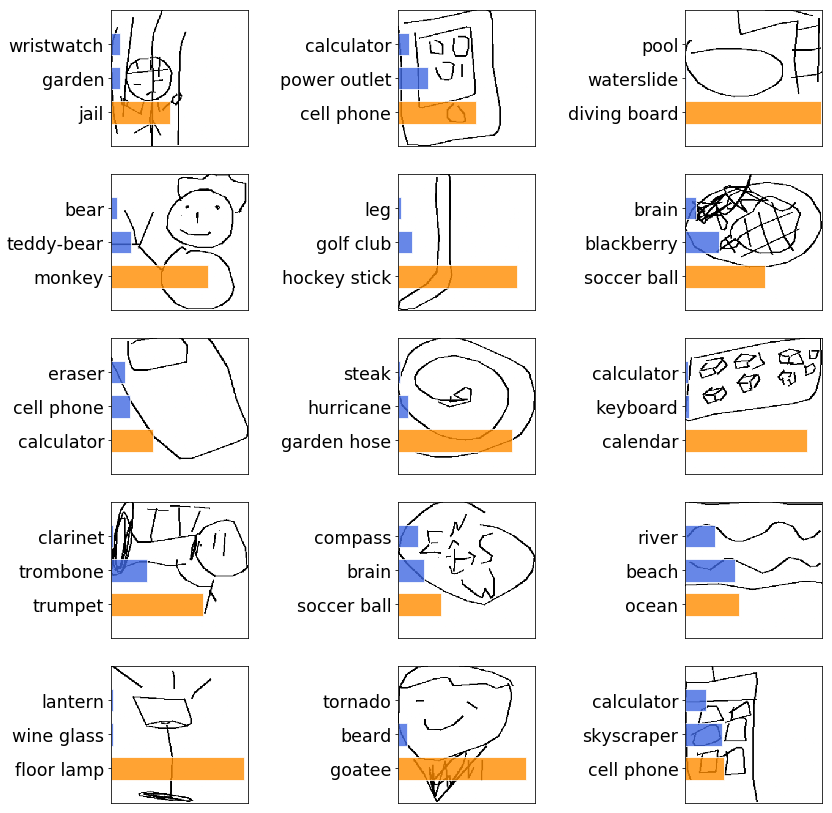

In [54]:
f, axes = plt.subplots(r, c, figsize=(15, 15), dpi=70)
for i, ax in zip(sample, axes.flat):
    img, _ = learn.data.test_ds[i]
    np_img = img.data.permute(1, 2, 0).numpy()
    cls, los = classes[i], losses[i]
    plot_predictions(np_img, dict(zip(cls, los)), ax=ax, sort_by_probability=True)

In [71]:
learn.data.train_ds.classes[learn.model(learn.data.test_ds[i][0].data[None].to('cuda:1')).argmax()]

'cell phone'

In [72]:
records = ['key_id,word']

for key, top_classes in zip(keys, classes):
    str_classes = ' '.join(['_'.join(c.split()) for c in top_classes])
    records.append(f'{key},{str_classes}')
    
with open('submit.csv', 'w') as file:
    for record in records:
        file.write(record + '\n')